In [556]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from plotly.offline import iplot, init_notebook_mode
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from datetime import datetime
import plotly.express as px

In [557]:
fact_order_lines_df=pd.read_csv("Atliq Marts Challenge/fact_order_lines.csv")
# fact_orders_aggregate_df=pd.read_csv("Atliq Marts Challenge/fact_orders_aggregate.csv")


dim_customers=pd.read_csv("Atliq Marts Challenge/dim_customers.csv")
dim_products=pd.read_csv("Atliq Marts Challenge/dim_products.csv")
dim_targets_orders=pd.read_csv("Atliq Marts Challenge/dim_targets_orders.csv")
dim_date=pd.read_csv("Atliq Marts Challenge/dim_date.csv")


In [558]:
# dim_order_placement_date=dim_date.rename(columns=lambda x: x.replace("date", "order_placement_date"))

In [559]:
# result =  pd.concat([fact_order_lines_df, fact_orders_aggregate_df], axis=1,join="outer")
# result =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
# esult =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
result =pd.merge( fact_order_lines_df ,dim_customers , how="outer",on=["customer_id"])
result =pd.merge( result ,dim_products , how="outer",on=["product_id"])
train_SC =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])
train_SC =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])

In [560]:
train_SC.head()

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,In Full,On Time,On Time In Full,customer_name,city,product_name,category,ontime_target%,infull_target%,otif_target%
0,FMR32603203,01-Mar-22,789603,25891203,460,02-Mar-22,03-Mar-22,460,1,0,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
1,FMR34603203,02-Mar-22,789603,25891203,477,04-Mar-22,03-Mar-22,477,1,1,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
2,FMR35603603,03-Mar-22,789603,25891203,195,05-Mar-22,05-Mar-22,195,1,1,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
3,FMR36603401,04-Mar-22,789603,25891203,453,06-Mar-22,06-Mar-22,453,1,1,1,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69
4,FMR38603203,06-Mar-22,789603,25891203,187,08-Mar-22,09-Mar-22,168,0,0,0,Info Stores,Vadodara,AM Butter 500,Dairy,92,75,69


In [561]:
np.sum(train_SC.isna())

order_id                0
order_placement_date    0
customer_id             0
product_id              0
order_qty               0
agreed_delivery_date    0
actual_delivery_date    0
delivery_qty            0
In Full                 0
On Time                 0
On Time In Full         0
customer_name           0
city                    0
product_name            0
category                0
ontime_target%          0
infull_target%          0
otif_target%            0
dtype: int64

In [562]:
train_SC.columns = [col.lower().replace(' ', '_') for col in train_SC.columns]
train_SC.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
train_SC.rename(columns=lambda x: x.replace("%", "_percent"), inplace=True)

In [563]:
train_SC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57096 entries, 0 to 57095
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   order_id               57096 non-null  object
 1   order_placement_date   57096 non-null  object
 2   customer_id            57096 non-null  int64 
 3   product_id             57096 non-null  int64 
 4   order_qty              57096 non-null  int64 
 5   agreed_delivery_date   57096 non-null  object
 6   actual_delivery_date   57096 non-null  object
 7   delivery_qty           57096 non-null  int64 
 8   in_full                57096 non-null  int64 
 9   on_time                57096 non-null  int64 
 10  on_time_in_full        57096 non-null  int64 
 11  customer_name          57096 non-null  object
 12  city                   57096 non-null  object
 13  product_name           57096 non-null  object
 14  category               57096 non-null  object
 15  ontime_target_perce

In [564]:
# feature = ['customer_name','product_name','delivery_qty','in_full','on_time','on_time_in_full','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
# feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']

train_SC = train_SC[feature]

In [565]:
train_SC = train_SC.drop_duplicates()
# Check for duplicated rows
duplicated_rows = train_SC.duplicated()

# Filter the DataFrame to show duplicated rows
duplicated_df = train_SC[duplicated_rows]

print("Duplicated Rows:")
print(duplicated_df)

Duplicated Rows:
Empty DataFrame
Columns: [customer_name, product_name, city, category, ontime_target_percent, infull_target_percent, otif_target_percent, order_qty]
Index: []


In [566]:
Obj_feature = ['customer_name','product_name','city','category']
for e in Obj_feature:
    tmp = pd.get_dummies(train_SC[e],drop_first=True)
    train_SC.drop([e],axis=1,inplace=True)
    train_SC = pd.concat([train_SC,tmp],axis=1)
train_SC.shape

(44414, 39)

In [567]:
train_SCData=train_SC

In [568]:
xorderitemquantity=train_SCData .loc[:, train_SCData .columns !='order_qty']
yorderitemquantity=train_SCData['order_qty']
xorderitemquantity_train, xorderitemquantity_test,yorderitemquantity_train,yorderitemquantity_test = train_test_split(xorderitemquantity,yorderitemquantity,test_size = 0.3, random_state = 42)

In [569]:
scaler=MinMaxScaler()
xorderitemquantity_train=scaler.fit_transform(xorderitemquantity_train)
xorderitemquantity_test=scaler.transform(xorderitemquantity_test)

In [570]:
def regressionmodel(model_orderitemquantity,xorderitemquantity_train, xorderitemquantity_test,yorderitemquantity_train,yorderitemquantity_test):
    model_orderitemquantity=model_orderitemquantity.fit(xorderitemquantity_train,yorderitemquantity_train)#Fitting train data for Number of products per order

    yorderitemquantity_pred=model_orderitemquantity.predict(xorderitemquantity_test)#predicting Number of products per order with test data

    print('Model parameter used are:',model_orderitemquantity) #Printing the model to see which parameters are used

    print("MAE of Total amount per order is         :", metrics.mean_absolute_error(yorderitemquantity_test,yorderitemquantity_pred))  #Printing mean absolute error for predicting Number of products per order

    print("RMSE of Total amount per order is        :",np.sqrt(metrics.mean_squared_error(yorderitemquantity_test,yorderitemquantity_pred)))#Printing Root mean squared error for predicting Number of products per order

    return yorderitemquantity_test,yorderitemquantity_pred


In [571]:
model_orderitemquantity=LinearRegression()
yorderitemquantity_test,yorderitemquantity_pred=regressionmodel(model_orderitemquantity,xorderitemquantity_train, xorderitemquantity_test,yorderitemquantity_train,yorderitemquantity_test)
df = pd.DataFrame({"Actual": yorderitemquantity_test, "Predict": yorderitemquantity_pred})

Model parameter used are: LinearRegression()
MAE of Total amount per order is         : 56.81539692776735
RMSE of Total amount per order is        : 72.4634892271304


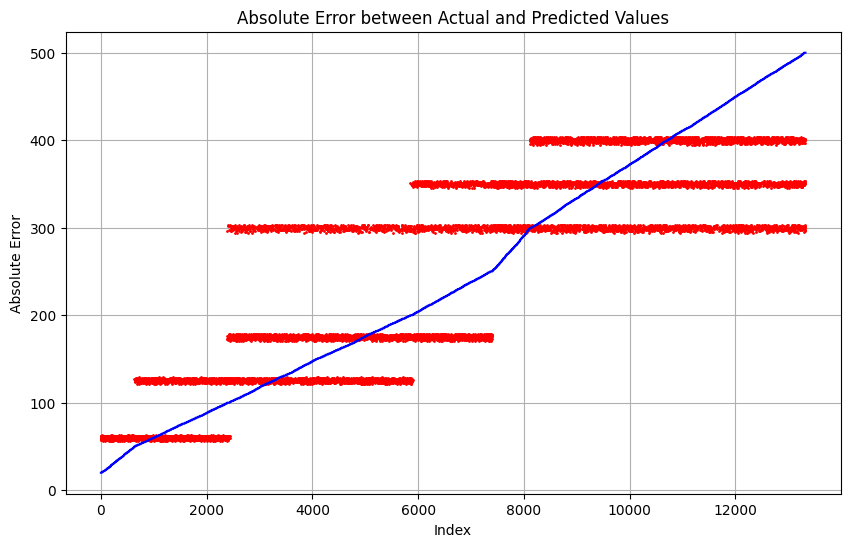

In [572]:
# Sort the DataFrame based on absolute error
df_sorted_Actual = df.sort_values(by='Actual')

x1=df_sorted_Actual['Predict'].to_numpy()
x2=df_sorted_Actual['Actual'].to_numpy()


plt.figure(figsize=(10, 6))
plt.plot(x1 ,color='red', marker='o', linestyle='', markersize=1)
plt.plot(x2, color='blue', label='Actual')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

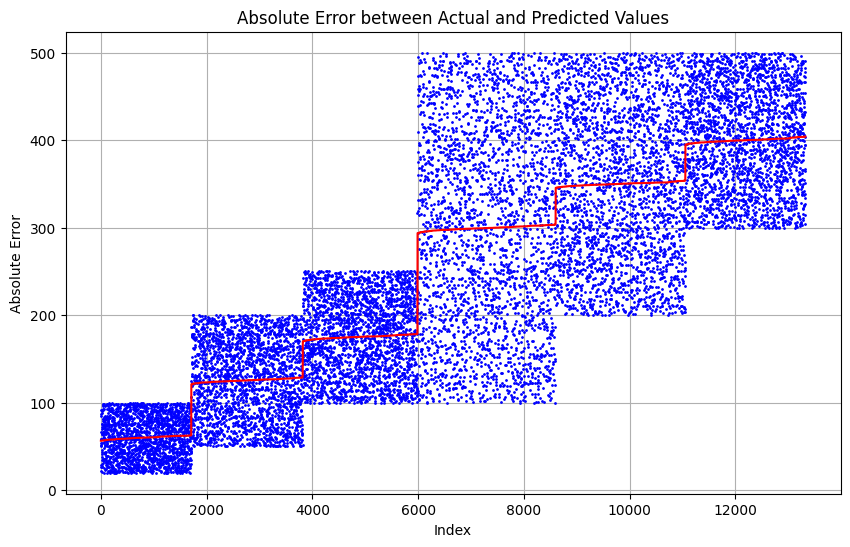

In [573]:
# Sort the DataFrame based on absolute error
df_sorted_Predict = df.sort_values(by='Predict')

x1=df_sorted_Predict['Actual'].to_numpy()
x2=df_sorted_Predict['Predict'].to_numpy()


plt.figure(figsize=(10, 6))
plt.plot(x1 ,color='blue', marker='o', linestyle='', markersize=1, label='Actual')
plt.plot(x2, color='red', label='Predict')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

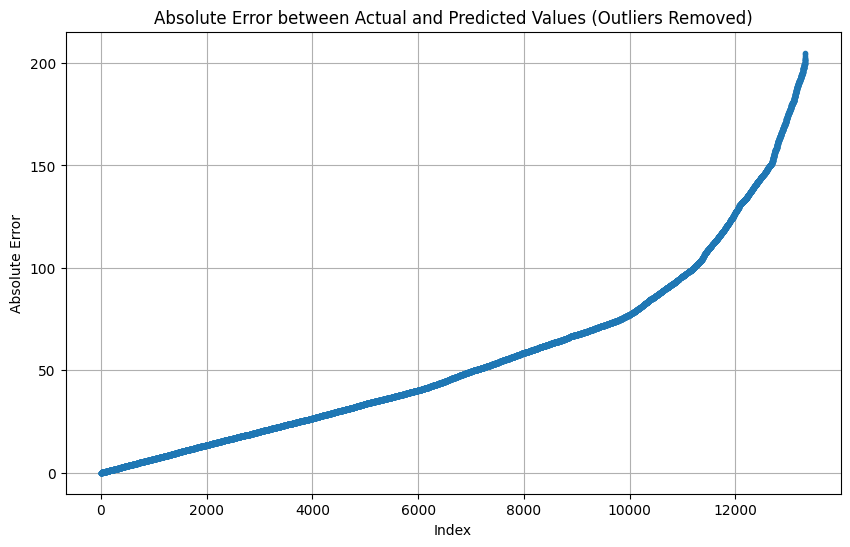

In [574]:
df['Abs_Error'] = abs(df['Actual'] - df['Predict'])

# Sort the DataFrame based on absolute error
df_sorted = df.sort_values(by='Abs_Error')

x1=df_sorted['Actual'].to_numpy()
x2=df_sorted['Predict'].to_numpy()
x3=df_sorted['Abs_Error'].to_numpy()
plt.figure(figsize=(10, 6))
plt.plot(x3, marker='.')
plt.title('Absolute Error between Actual and Predicted Values (Outliers Removed)')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

In [575]:
model_orderitemquantity = tree.DecisionTreeRegressor()
yorderitemquantity_test,yorderitemquantity_pred = regressionmodel(model_orderitemquantity,xorderitemquantity_train, xorderitemquantity_test,yorderitemquantity_train,yorderitemquantity_test)
df =pd.DataFrame({"Actual": yorderitemquantity_test, "Predict": yorderitemquantity_pred})


Model parameter used are: DecisionTreeRegressor()
MAE of Total amount per order is         : 57.33099858873556
RMSE of Total amount per order is        : 73.21908759657939


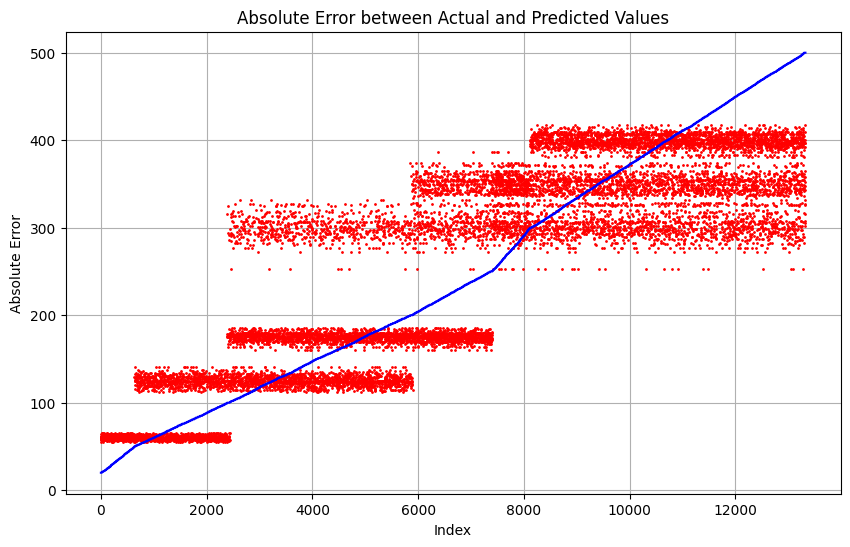

In [576]:
# Sort the DataFrame based on absolute error
df_sorted_Actual = df.sort_values(by='Actual')

x1=df_sorted_Actual['Predict'].to_numpy()
x2=df_sorted_Actual['Actual'].to_numpy()


plt.figure(figsize=(10, 6))
plt.plot(x1 ,color='red', marker='o', linestyle='', markersize=1)
plt.plot(x2, color='blue', label='Actual')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

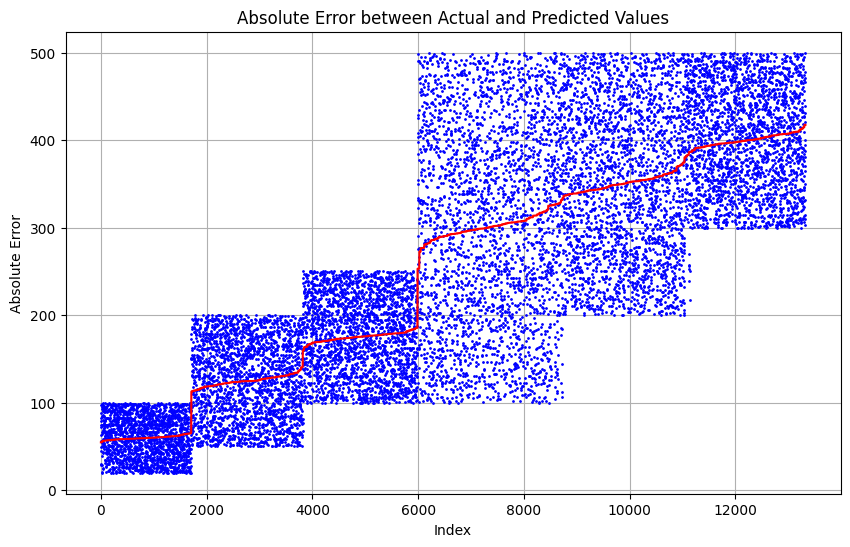

In [577]:
# Sort the DataFrame based on absolute error
df_sorted_Predict = df.sort_values(by='Predict')

x1=df_sorted_Predict['Actual'].to_numpy()
x2=df_sorted_Predict['Predict'].to_numpy()


plt.figure(figsize=(10, 6))
plt.plot(x1 ,color='blue', marker='o', linestyle='', markersize=1, label='Actual')
plt.plot(x2, color='red', label='Predict')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

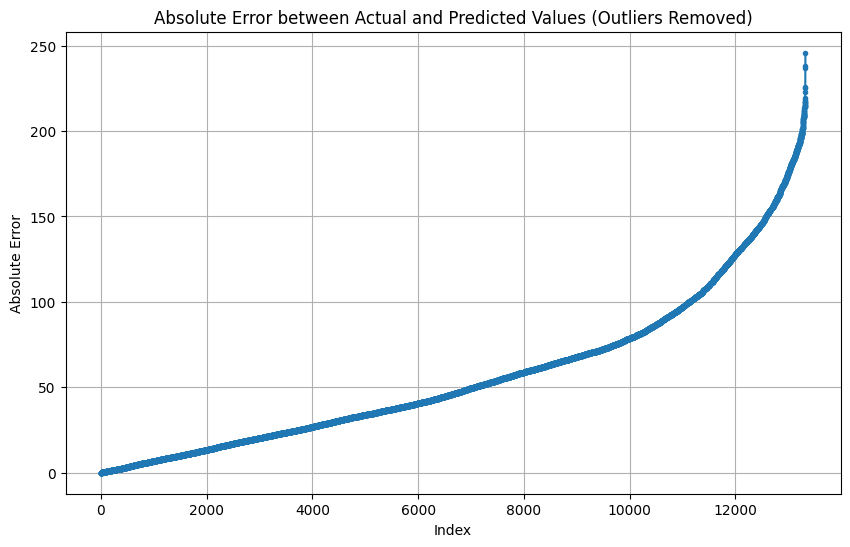

In [578]:
df['Abs_Error'] = abs(df['Actual'] - df['Predict'])

# Sort the DataFrame based on absolute error
df_sorted = df.sort_values(by='Abs_Error')

x1=df_sorted['Actual'].to_numpy()
x2=df_sorted['Predict'].to_numpy()
x3=df_sorted['Abs_Error'].to_numpy()
plt.figure(figsize=(10, 6))
plt.plot(x3, marker='.')
plt.title('Absolute Error between Actual and Predicted Values (Outliers Removed)')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

In [579]:
model_orderitemquantity = RandomForestRegressor(n_estimators=100,max_depth=20, random_state=40)
yorderitemquantity_test,yorderitemquantity_pred = regressionmodel(model_orderitemquantity,xorderitemquantity_train, xorderitemquantity_test,yorderitemquantity_train,yorderitemquantity_test)
df = pd.DataFrame({"Actual": yorderitemquantity_test, "Predict": yorderitemquantity_pred})

Model parameter used are: RandomForestRegressor(max_depth=20, random_state=40)
MAE of Total amount per order is         : 57.29899712154215
RMSE of Total amount per order is        : 73.16240266376367


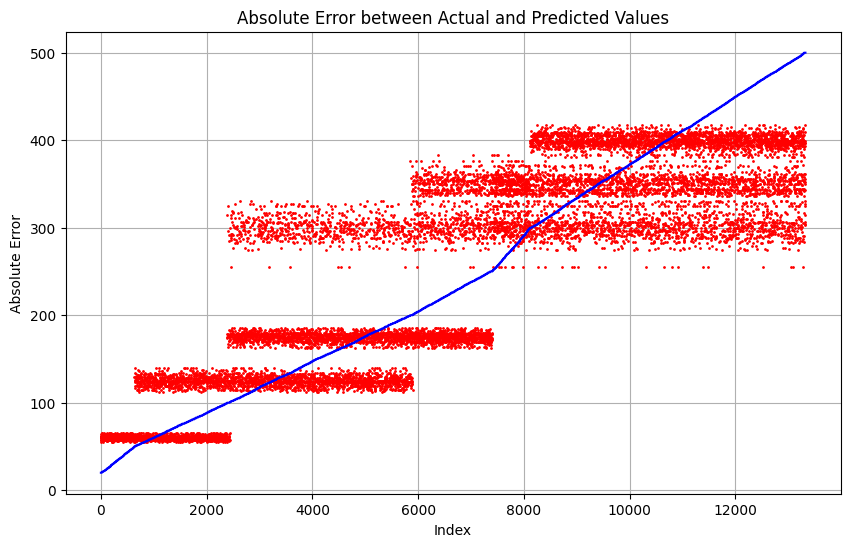

In [580]:
# Sort the DataFrame based on absolute error
df_sorted_Actual = df.sort_values(by='Actual')

x1=df_sorted_Actual['Predict'].to_numpy()
x2=df_sorted_Actual['Actual'].to_numpy()


plt.figure(figsize=(10, 6))
plt.plot(x1 ,color='red', marker='o', linestyle='', markersize=1)
plt.plot(x2, color='blue', label='Actual')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

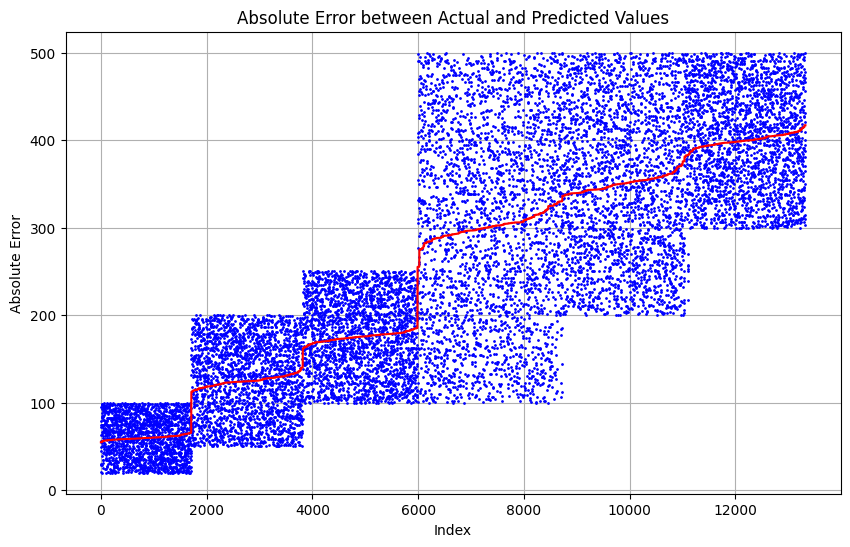

In [581]:
# Sort the DataFrame based on absolute error
df_sorted_Predict = df.sort_values(by='Predict')

x1=df_sorted_Predict['Actual'].to_numpy()
x2=df_sorted_Predict['Predict'].to_numpy()


plt.figure(figsize=(10, 6))
plt.plot(x1 ,color='blue', marker='o', linestyle='', markersize=1, label='Actual')
plt.plot(x2, color='red', label='Predict')

plt.title('Absolute Error between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()

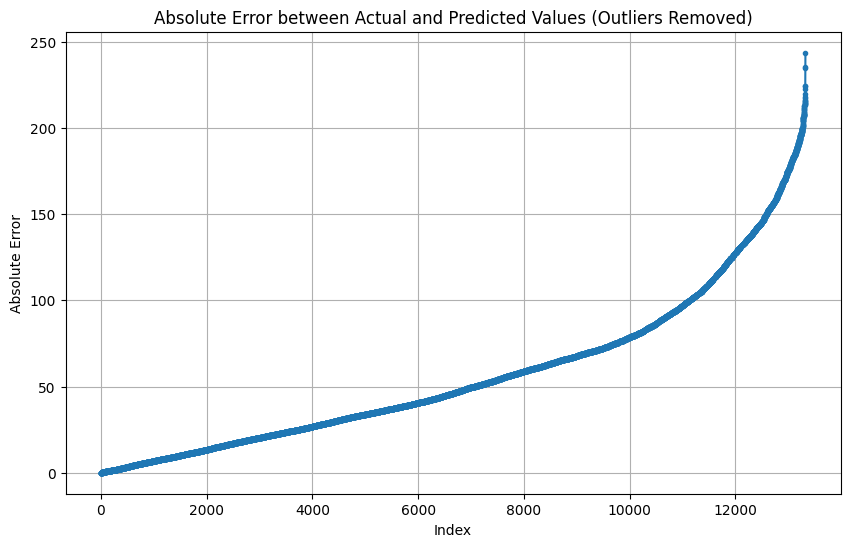

In [582]:
df['Abs_Error'] = abs(df['Actual'] - df['Predict'])

# Sort the DataFrame based on absolute error
df_sorted = df.sort_values(by='Abs_Error')

x1=df_sorted['Actual'].to_numpy()
x2=df_sorted['Predict'].to_numpy()
x3=df_sorted['Abs_Error'].to_numpy()
plt.figure(figsize=(10, 6))
plt.plot(x3, marker='.')
plt.title('Absolute Error between Actual and Predicted Values (Outliers Removed)')
plt.xlabel('Index')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()